# Data Casal Montserratina

In [4]:
#Data Manipulation

import pandas as pd
import numpy as np
from datetime import timedelta

import os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# for EDA
from ydata_profiling import ProfileReport 

#Parameters Dict
parameters = {
    "paths": {
        "2022_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202201_202206.csv",
        "2022_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202207_202212.csv",
        "2023_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202301_202306.csv",
        "2023_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202307_202312.csv"
    }
}

In [5]:
ruta_data = "../data/data_casal_montserratina/"

In [6]:
df1 = pd.read_csv(parameters["paths"]["2022_01_06"], delimiter=";")
df2 = pd.read_csv(parameters["paths"]["2022_07_12"], delimiter=";")
df3 = pd.read_csv(parameters["paths"]["2023_01_06"], delimiter=";")
df4 = pd.read_csv(parameters["paths"]["2023_07_12"], delimiter=";")

In [7]:
# hago un concat de los 4 datasets, para Unir los DataFrames uno a continuación del otro
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [8]:
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%d/%m/%Y %H:%M")
df.rename(columns={'TimeStamp': 'Date'}, inplace=True)
df.rename(columns={'Valor': 'Consumo'}, inplace=True)
df.rename(columns={'Període tarifari': 'Periode_tarifari'}, inplace=True)
df.rename(columns={'Tipus lectura': 'Tipus_lectura'}, inplace=True)

In [9]:
df

Date  Consumo  Periode_tarifari Tipus_lectura
0     2022-01-01 00:00:00        6                 6          Real
1     2022-01-01 01:00:00        6                 6          Real
2     2022-01-01 02:00:00        5                 6          Real
3     2022-01-01 03:00:00        7                 6          Real
4     2022-01-01 04:00:00        7                 6          Real
...                   ...      ...               ...           ...
16315 2023-12-31 19:00:00        2                 6          Real
16316 2023-12-31 20:00:00        2                 6          Real
16317 2023-12-31 21:00:00        2                 6          Real
16318 2023-12-31 22:00:00        2                 6          Real
16319 2023-12-31 23:00:00        2                 6          Real

[16320 rows x 4 columns]

## EDA

In [10]:
# Generate the report
profile = ProfileReport(df,title="monserratina_2022_2023", tsmode=True, sortby="Date", correlations={"auto": {"calculate": False}})

# Save the report to .html
profile.to_file("monserratina_2022_2023.html")

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# Elimino la columna "Tipo de Lectura" & "Periode Tarifari"
df = df.drop(columns=["Tipus_lectura", "Periode_tarifari"])

# Missing values

In [12]:
#Prints the NaN Values per Column of a dataset
def checkNaNValues(df):
    return print(f"NaN Count per Column", df.isna().any(axis=1).sum())

#Checks if there is any missing time series
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='h')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates, date_range

In [13]:
checkNaNValues(df)
missing_dates, date_range = checkMissingData(df, 'Date')

NaN Count per Column 0
Number of Missing Values: 1202


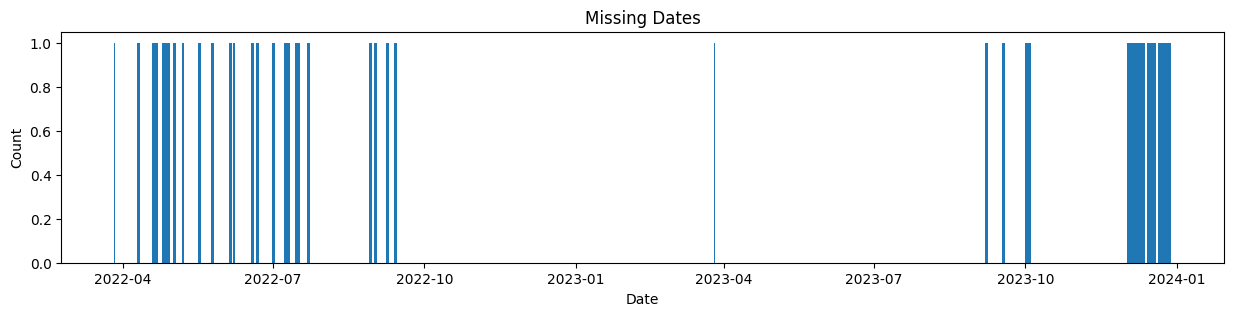

In [14]:
plt.figure(figsize=(15, 3))
plt.bar(missing_dates, [1] * len(missing_dates))
plt.title("Missing Dates")
plt.xlabel("Date")
plt.ylabel("Count")
# plt.xticks(rotation=0)
plt.show()

In [15]:
# para ver un trozo de las fechas faltantes.

print(df[(df["Date"]>"2022-04-09 22:00:00") & (df["Date"]<"2022-04-11 01:00:00")])

# >>>>> notar que entre las 23 del 9/4 a las 00 del 11/4 no hay datos. 

                    Date  Consumo
2374 2022-04-09 23:00:00        2
2375 2022-04-11 00:00:00        2


### rellenar los huecos de Date

In [16]:
new_df = df.drop_duplicates(keep=False) # 
#new_df

In [17]:
new_df.set_index("Date", inplace=True)
#new_df

In [18]:
# Reindexa el DataFrame con el nuevo rango de fechas y rellena los valores faltantes con NaN
data_reindexed = new_df.reindex(date_range)
#data_reindexed

In [19]:
data_reindexed.reset_index(inplace=True)
data_reindexed.rename(columns={'index': 'Date'}, inplace=True)

In [20]:
data_reindexed

Date  Consumo
0     2022-01-01 00:00:00      6.0
1     2022-01-01 01:00:00      6.0
2     2022-01-01 02:00:00      5.0
3     2022-01-01 03:00:00      7.0
4     2022-01-01 04:00:00      7.0
...                   ...      ...
17515 2023-12-31 19:00:00      2.0
17516 2023-12-31 20:00:00      2.0
17517 2023-12-31 21:00:00      2.0
17518 2023-12-31 22:00:00      2.0
17519 2023-12-31 23:00:00      2.0

[17520 rows x 2 columns]

Notar que ahora aparecen rellenas!... con Nulls, tiny bam! 

In [21]:
print(data_reindexed[(data_reindexed["Date"]>"2022-04-09 22:00:00") & (data_reindexed["Date"]<"2022-04-11 01:00:00")])

                    Date  Consumo
2375 2022-04-09 23:00:00      2.0
2376 2022-04-10 00:00:00      NaN
2377 2022-04-10 01:00:00      NaN
2378 2022-04-10 02:00:00      NaN
2379 2022-04-10 03:00:00      NaN
2380 2022-04-10 04:00:00      NaN
2381 2022-04-10 05:00:00      NaN
2382 2022-04-10 06:00:00      NaN
2383 2022-04-10 07:00:00      NaN
2384 2022-04-10 08:00:00      NaN
2385 2022-04-10 09:00:00      NaN
2386 2022-04-10 10:00:00      NaN
2387 2022-04-10 11:00:00      NaN
2388 2022-04-10 12:00:00      NaN
2389 2022-04-10 13:00:00      NaN
2390 2022-04-10 14:00:00      NaN
2391 2022-04-10 15:00:00      NaN
2392 2022-04-10 16:00:00      NaN
2393 2022-04-10 17:00:00      NaN
2394 2022-04-10 18:00:00      NaN
2395 2022-04-10 19:00:00      NaN
2396 2022-04-10 20:00:00      NaN
2397 2022-04-10 21:00:00      NaN
2398 2022-04-10 22:00:00      NaN
2399 2022-04-10 23:00:00      NaN
2400 2022-04-11 00:00:00      2.0


## ahora a rellenar esos NaN!

- calcular el consumo promedio por hora
- reemplazar los NaN por el promedio de su hora

In [22]:
df2 = data_reindexed.copy()

In [23]:
# 2. Agrupa los datos por hora y calcula el promedio del consumo para cada hora
consumo_promedio_por_hora = df2.groupby(df['Date'].dt.hour)['Consumo'].mean()

# Imprime el consumo promedio por hora
print(consumo_promedio_por_hora)

Date
0.0      2.919877
1.0      2.909091
2.0      2.846986
3.0      2.870170
4.0      2.958398
5.0      3.394453
6.0      4.063174
7.0      4.950693
8.0      5.873652
9.0      7.200308
10.0     7.751926
11.0     7.462250
12.0     6.963020
13.0     5.653313
14.0     5.023112
15.0     4.876733
16.0     6.419106
17.0     8.731895
18.0    10.226502
19.0    11.283513
20.0     9.485362
21.0     6.875193
22.0     4.357473
23.0     2.959938
Name: Consumo, dtype: float64


In [24]:
# Rellenar los NaNs en la columna de consumo de df2 utilizando los promedios calculados por hora
df2['Consumo'] = df2['Consumo'].fillna(df2['Date'].dt.hour.map(consumo_promedio_por_hora))

In [25]:
print(df2[(df2["Date"]>"2022-04-09 22:00:00") & (df2["Date"]<"2022-04-11 01:00:00")])
print(df2.shape)


                    Date    Consumo
2375 2022-04-09 23:00:00   2.000000
2376 2022-04-10 00:00:00   2.919877
2377 2022-04-10 01:00:00   2.909091
2378 2022-04-10 02:00:00   2.846986
2379 2022-04-10 03:00:00   2.870170
2380 2022-04-10 04:00:00   2.958398
2381 2022-04-10 05:00:00   3.394453
2382 2022-04-10 06:00:00   4.063174
2383 2022-04-10 07:00:00   4.950693
2384 2022-04-10 08:00:00   5.873652
2385 2022-04-10 09:00:00   7.200308
2386 2022-04-10 10:00:00   7.751926
2387 2022-04-10 11:00:00   7.462250
2388 2022-04-10 12:00:00   6.963020
2389 2022-04-10 13:00:00   5.653313
2390 2022-04-10 14:00:00   5.023112
2391 2022-04-10 15:00:00   4.876733
2392 2022-04-10 16:00:00   6.419106
2393 2022-04-10 17:00:00   8.731895
2394 2022-04-10 18:00:00  10.226502
2395 2022-04-10 19:00:00  11.283513
2396 2022-04-10 20:00:00   9.485362
2397 2022-04-10 21:00:00   6.875193
2398 2022-04-10 22:00:00   4.357473
2399 2022-04-10 23:00:00   2.959938
2400 2022-04-11 00:00:00   2.000000
(17520, 2)


YA no hay huecos (hay 17520 filas). y los NaNs fueron reemplazados correctamente. 

## ahora hago el upsampling a 15 min

In [26]:
df_upsampled = df2.copy()

In [27]:
df_upsampled.set_index("Date", inplace=True)

In [28]:
df_upsampled = df_upsampled.resample('15min').interpolate(method='time')
df_upsampled

Consumo
Date                        
2022-01-01 00:00:00      6.0
2022-01-01 00:15:00      6.0
2022-01-01 00:30:00      6.0
2022-01-01 00:45:00      6.0
2022-01-01 01:00:00      6.0
...                      ...
2023-12-31 22:00:00      2.0
2023-12-31 22:15:00      2.0
2023-12-31 22:30:00      2.0
2023-12-31 22:45:00      2.0
2023-12-31 23:00:00      2.0

[70077 rows x 1 columns]

In [29]:
# Guardar el DataFrame como pickle (se guarda el dataframe, manteniendo su estado actual)
nombre_archivo = "consumoMonserratina_2022_2023.pkl"
df_upsampled.to_pickle(os.path.join(ruta_data, nombre_archivo))
print("DataFrame guardado con Pickle,b correctamente.")

DataFrame guardado con Pickle,b correctamente.


# Outliers

In [30]:
df3 = df_upsampled.copy()

In [31]:
df3.reset_index(inplace=True)

In [32]:
df3

Date  Consumo
0     2022-01-01 00:00:00      6.0
1     2022-01-01 00:15:00      6.0
2     2022-01-01 00:30:00      6.0
3     2022-01-01 00:45:00      6.0
4     2022-01-01 01:00:00      6.0
...                   ...      ...
70072 2023-12-31 22:00:00      2.0
70073 2023-12-31 22:15:00      2.0
70074 2023-12-31 22:30:00      2.0
70075 2023-12-31 22:45:00      2.0
70076 2023-12-31 23:00:00      2.0

[70077 rows x 2 columns]

In [33]:
def getNumberOfOutliersPerColumn(df, columns_list):
    for col in columns_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        #Calcular los límites inferiores y superiores para identificar outliers
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr

        outliers = ((df[col] < lim_inf) | (df[col] > lim_sup))
        print(f"For {col} Column, the Number of Outliers is {outliers.sum()}. Sus limites son {lim_inf} y {lim_sup}.\n")


getNumberOfOutliersPerColumn(df3, df3.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 7099. Sus limites son -4.75 y 13.25.



In [34]:
df3.describe()

Date       Consumo
count                70077  70077.000000
mean   2022-12-31 23:30:00      5.685700
min    2022-01-01 00:00:00      0.000000
25%    2022-07-02 11:45:00      2.000000
50%    2022-12-31 23:30:00      2.909091
75%    2023-07-02 11:15:00      6.500000
max    2023-12-31 23:00:00     68.000000
std                    NaN      7.416536

In [35]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df3['Date'],  # x-axis
    y=df3['Consumo'],  # y-axis
    mode='lines',  # Connect data points with lines
    name='Line'  # Name in the legend
))

# Layout parameters
fig.update_layout(
    title='Consumo Electrico Casal La Monserratina - Años 2022 y 2023',  # Title
    xaxis_title='Consumo [kW]',  # y-axis name
    yaxis_title='',  # x-axis name
    xaxis_tickangle=0,  # Set the x-axis label angle
    showlegend=False,     # Display the legend
)

# Merge Consumo con PPV

In [71]:
# Load the DataFrame from the pickle file
nombre_archivo = "LaMonserratina_weather_&_PV_2022_2023.pkl"
df_PV = pd.read_pickle(os.path.join(ruta_data, nombre_archivo))
df_PV.rename(columns={"timestamp_local": "Date"}, inplace=True)
df_PV.drop(columns=["suma_produccion_diaria"], inplace=True)
#df_PV.set_index("Date", inplace=True)
df_PV.head(3)

Date  temp [C]  wind_spd [m/s]  dhi [W/m^2]  ghi [W/m^2]  \
0 2022-01-01 00:00:00      10.7             1.0          0.0          0.0   
1 2022-01-01 00:15:00      10.7             1.4          0.0          0.0   
2 2022-01-01 00:30:00      10.7             1.8          0.0          0.0   

   dni [W/m^2]  clouds [%]  dewpt [C]  rh [%]  Temp interna Modulo   PV  Year  \
0          0.0       87.00      9.500    92.0            22.066196  0.0  2022   
1          0.0       80.75      9.325    91.0            22.066196  0.0  2022   
2          0.0       74.50      9.150    90.0            22.066196  0.0  2022   

   Month  Hour  DayOfWeek  DayOfYear  Day  Minute  
0      1     0          5          1    1       0  
1      1     0          5          1    1      15  
2      1     0          5          1    1      30

In [72]:
checkNaNValues(df_PV)
missing_dates, date_range = checkMissingData(df_PV, 'Date')

NaN Count per Column 0
Number of Missing Values: 0


In [93]:
#df3.set_index("Date", inplace=True)
#df3.drop(columns=["index"], inplace=True)
df3.rename(columns={"Consumo": "Consumo [kW]"}, inplace=True)
df3.head(3)

Date  Consumo [kW]
0 2022-01-01 00:00:00           6.0
1 2022-01-01 00:15:00           6.0
2 2022-01-01 00:30:00           6.0

In [120]:
df4 = df3.merge(df_PV, how="inner", on=["Date", "Date"])

hay un probma con las unidades, Consumo de Red esta en kW, y PV en W.. ajusto PV/1000. y agrego las unidades a los nombres para evitar confusiones

In [121]:
df4.rename(columns={'Consumo [kW]': 'Consumo_red [kW]'}, inplace=True)

df4["PV [kW]"] = (df4["PV"]/1000000).round(3)
df4.drop(columns=["PV"], inplace=True)

In [122]:
df4["Consumo_total [kW]"] = df4["Consumo_red [kW]"] + df4["PV [kW]"]

In [123]:
df4.sample(10)

Date  Consumo_red [kW]  temp [C]  wind_spd [m/s]  \
18575 2022-07-13 11:45:00             20.00    29.175          3.3500   
5163  2022-02-23 18:45:00             10.75    13.450          4.6175   
790   2022-01-09 05:30:00              8.00    10.850          2.3000   
30192 2022-11-11 12:00:00              0.00    21.000          8.2750   
62597 2023-10-15 01:15:00              2.00    19.500          3.3475   
32201 2022-12-02 10:15:00              5.50     8.575          5.7000   
48233 2023-05-18 10:15:00              0.75    18.600          2.8500   
29705 2022-11-06 10:15:00              0.00    15.025          3.9675   
57789 2023-08-25 23:15:00              2.25    28.425          2.3250   
23241 2022-08-31 02:15:00              2.00    27.550          3.6000   

       dhi [W/m^2]  ghi [W/m^2]  dni [W/m^2]  clouds [%]  dewpt [C]  rh [%]  \
18575       115.25       839.50       885.50        0.00     21.725   64.50   
5163          9.25        14.50        79.75       15.25     10.725   83.75   
790           0.00         0.00         0.00       25.00      3.300   59.50   
30192        97.00       498.00       802.00       42.00     14.200   65.00   
62597         0.00         0.00         0.00       21.75     16.100   80.50   
32201        75.00       272.25       658.25       32.75      1.600   61.50   
48233       103.50       630.25       828.50       30.75      8.675   52.50   
29705        85.75       375.00       731.75       23.25      4.500   49.50   
57789         0.00         0.00         0.00       15.25     24.125   77.50   
23241         0.00         0.00         0.00       15.25     23.200   77.25   

       Temp interna Modulo  Year  Month  Hour  DayOfWeek  DayOfYear  Day  \
18575            50.517664  2022      7    11          2        194   13   
5163             25.119196  2022      2    18          2         54   23   
790              22.133952  2022      1     5          6          9    9   
30192            44.929000  2022     11    12          4        315   11   
62597            26.041226  2023     10     1          6        288   15   
32201            36.052541  2022     12    10          4        336    2   
48233            44.446610  2023      5    10          3        138   18   
29705            40.634948  2022     11    10          6        310    6   
57789            30.072720  2023      8    23          4        237   25   
23241            29.677475  2022      8     2          2        243   31   

       Minute  PV [kW]  Consumo_total [kW]  
18575      45    4.399              24.399  
5163       45    0.491              11.241  
790        30    0.000               8.000  
30192       0    4.195               4.195  
62597      15    0.000               2.000  
32201      15    3.718               9.218  
48233      15    4.352               5.102  
29705      15    3.975               3.975  
57789      15    0.000               2.250  
23241      15    0.000               2.000

In [150]:
# Guardar el DataFrame como CSV
nombre_archivo = "LaMonserratina_Consumo_weather_&_PV_2022_2023.pkl"
ruta_completa = os.path.join(ruta_data, nombre_archivo)

df_PV.to_pickle(ruta_completa)

# Correlation Matrix

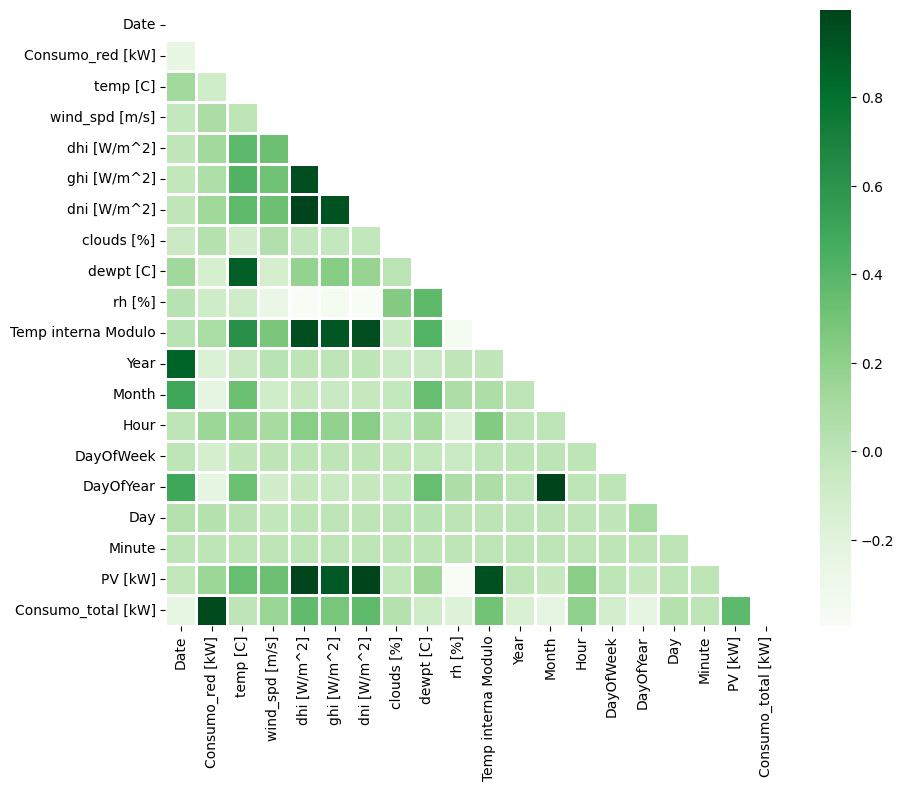

In [149]:
# Calcula la matriz de correlación completa
correlation_matrix = df4.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Imprime la matriz de correlación del cuadrante inferior
#plotting the heatmap for correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, square=True, cmap='Greens', linewidths=2, linecolor='white');

1.81956